In [36]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.distributions.transforms import OrderedTransform
from numpyro.diagnostics import effective_sample_size
from numpyro.infer import MCMC, NUTS, Predictive

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

In [4]:
reedfrogs = pd.read_csv('../data/reedfrogs.csv', sep=';')
d = reedfrogs
d["tank"] = jnp.arange(d.shape[0])
d["is_pred"] = d.pred.map({'no': 0, 'pred': 1})
d["is_big"] = d["size"].map({'small': 0, 'big': 1})
d.sample(3)

,density,pred,size,surv,propsurv,tank,is_pred,is_big
0,10,no,big,9,0.90,0,0,1
27,25,pred,big,9,0.36,27,1,1
43,35,pred,big,14,0.40,43,1,1


In [5]:
data = {
    "density": d.density.values,
    "tank": d.tank.values,
    "is_pred": d.is_pred.values,
    "is_big": d.is_big.values,
    "surv": d.surv.values,
}

def model(tank=None, density=None, is_pred=None, is_big=None, surv=None):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    logit_p = a[tank]
    p = numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m1_base = MCMC(NUTS(model), 500, 1000, num_chains=4)
m1_base.run(random.PRNGKey(0), **data)
m1_base.print_summary()
m1_base_post = m1_base.get_samples(group_by_chain=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.14      0.89      2.09      0.65      3.53   3910.17      1.00
      a[1]      3.06      1.11      2.95      1.29      4.84   4169.92      1.00
      a[2]      1.00      0.67      0.96     -0.06      2.11   5468.60      1.00
      a[3]      3.10      1.14      2.98      1.25      4.83   3526.69      1.00
      a[4]      2.15      0.90      2.09      0.74      3.68   4235.20      1.00
      a[5]      2.13      0.88      2.09      0.82      3.65   4285.22      1.00
      a[6]      3.07      1.09      2.95      1.28      4.79   4604.23      1.00
      a[7]      2.14      0.88      2.08      0.67      3.50   3789.40      1.00
      a[8]     -0.17      0.60     -0.16     -1.21      0.77   5025.91      1.00
      a[9]      2.14      0.90      2.07      0.67      3.49   3985.27      1.00
     a[10]      1.00      0.68      0.98     -0.09      2.11   5232.19      1.00
     a[11]      0.58      0

In [6]:
def model(tank, density, is_pred, is_big, surv):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    bS = numpyro.sample("bS", dist.Normal(0, 1))
    logit_p = a[tank] + bS * is_big
    p = numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m1_size = MCMC(NUTS(model), 500, 1000, num_chains=4)
m1_size.run(random.PRNGKey(0), **data)
m1_size.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.37      0.91      2.33      0.93      3.93   2090.02      1.00
      a[1]      3.27      1.12      3.19      1.51      5.07   3064.86      1.00
      a[2]      1.26      0.81      1.23     -0.05      2.61   1461.56      1.00
      a[3]      3.29      1.17      3.20      1.39      5.17   2669.93      1.00
      a[4]      2.19      0.91      2.11      0.79      3.63   3533.00      1.00
      a[5]      2.19      0.87      2.13      0.74      3.56   3552.21      1.00
      a[6]      3.12      1.11      3.04      1.33      4.84   4528.45      1.00
      a[7]      2.17      0.87      2.11      0.77      3.57   4315.22      1.00
      a[8]      0.09      0.74      0.09     -1.13      1.29   1329.24      1.00
      a[9]      2.36      0.93      2.30      0.78      3.78   2226.27      1.00
     a[10]      1.26      0.78      1.24     -0.07      2.53   1544.06      1.00
     a[11]      0.83      0

In [7]:
def model(tank, density, is_pred, is_big, surv):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    bP = numpyro.sample("bP", dist.Normal(0, 1))
    logit_p = a[tank] + bP * is_pred
    p = numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m1_pred = MCMC(NUTS(model), 500, 1000, num_chains=4)
m1_pred.run(random.PRNGKey(0), **data)
m1_pred.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.45      0.66      2.44      1.37      3.52   5176.14      1.00
      a[1]      2.92      0.72      2.90      1.79      4.14   5600.22      1.00
      a[2]      1.66      0.62      1.65      0.67      2.72   4699.26      1.00
      a[3]      2.93      0.77      2.88      1.73      4.23   5339.56      1.00
      a[4]      2.47      0.69      2.45      1.31      3.54   4072.89      1.00
      a[5]      2.46      0.66      2.45      1.31      3.49   4904.17      1.00
      a[6]      2.91      0.72      2.87      1.84      4.21   4779.79      1.00
      a[7]      2.45      0.69      2.42      1.36      3.60   4333.40      1.00
      a[8]      2.15      0.58      2.17      1.20      3.08   2064.11      1.00
      a[9]      3.50      0.62      3.49      2.55      4.58   2978.99      1.00
     a[10]      2.94      0.59      2.92      1.99      3.89   2414.17      1.00
     a[11]      2.67      0

In [8]:
def model(tank, density, is_pred, is_big, surv):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    bP = numpyro.sample("bP", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 1))
    logit_p = a[tank] + bP * is_big + bS * is_big
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m1_pred_size = MCMC(NUTS(model), 500, 1000, num_chains=4)
m1_pred_size.run(random.PRNGKey(0), **data)
m1_pred_size.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.43      0.94      2.40      0.88      3.94   1258.04      1.00
      a[1]      3.37      1.15      3.27      1.56      5.20   1427.04      1.00
      a[2]      1.35      0.80      1.33      0.12      2.77    722.24      1.00
      a[3]      3.36      1.20      3.30      1.38      5.20   1456.17      1.00
      a[4]      2.19      0.90      2.12      0.81      3.65   3080.06      1.00
      a[5]      2.21      0.92      2.13      0.71      3.63   2785.38      1.00
      a[6]      3.14      1.11      3.04      1.43      4.96   2975.90      1.00
      a[7]      2.22      0.90      2.15      0.67      3.62   2527.81      1.00
      a[8]      0.17      0.76      0.18     -1.05      1.47    703.29      1.00
      a[9]      2.46      0.96      2.41      0.90      3.96   1243.59      1.00
     a[10]      1.35      0.80      1.32     -0.02      2.60    782.65      1.00
     a[11]      0.94      0

In [9]:
def model(tank, density, is_pred, is_big, surv):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    bP = numpyro.sample("bP", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 1))
    bPS = numpyro.sample("bPS", dist.Normal(0, 1))
    logit_p = a[tank] + bP * is_pred + bS * is_big + bPS * is_pred * is_big
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m1_pred_size_int = MCMC(NUTS(model), 500, 1000, num_chains=4)
m1_pred_size_int.run(random.PRNGKey(0), **data)
m1_pred_size_int.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.34      0.70      2.34      1.17      3.46   1638.22      1.00
      a[1]      2.78      0.73      2.74      1.68      4.03   1731.41      1.00
      a[2]      1.64      0.67      1.66      0.56      2.76   1325.00      1.01
      a[3]      2.76      0.73      2.73      1.52      3.93   1482.76      1.00
      a[4]      2.43      0.67      2.42      1.22      3.43   2118.80      1.00
      a[5]      2.42      0.66      2.40      1.36      3.52   2051.68      1.00
      a[6]      2.79      0.69      2.77      1.62      3.87   2190.86      1.00
      a[7]      2.40      0.66      2.40      1.26      3.43   2398.58      1.00
      a[8]      2.40      0.59      2.41      1.43      3.33   1120.65      1.01
      a[9]      3.60      0.65      3.58      2.56      4.65   1261.15      1.00
     a[10]      3.11      0.58      3.11      2.19      4.13   1134.69      1.00
     a[11]      2.87      0

In [10]:
az.compare(
    {
        "m1_base": az.from_numpyro(m1_base),
        "m1_size": az.from_numpyro(m1_size),
        "m1_pred": az.from_numpyro(m1_pred),
        "m1_pred_size": az.from_numpyro(m1_pred_size),
        "m1_pred_size_int": az.from_numpyro(m1_pred_size_int),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m1_pred,0,198.895,19.1615,0,0.273705,7.22476,0,True,deviance
m1_pred_size_int,1,199.033,18.7947,0.137623,0.328695,7.17953,3.29303,True,deviance
m1_base,2,200.607,21.133,1.71222,0.153656,8.97771,5.57326,True,deviance
m1_size,3,200.752,21.1412,1.85707,0.128616,9.59861,5.3667,True,deviance
m1_pred_size,4,201.012,21.3061,2.11666,0.115328,7.27393,5.39718,True,deviance


In [11]:
def plot_post_check(mcmc, scatter_data, pred_inputs, outcome_var):
    x,y = scatter_data
    post = mcmc.get_samples()
    pred = Predictive(mcmc.sampler.model, post)(random.PRNGKey(1), **data)[outcome_var]

    plt.scatter(x,y)
    plt.errorbar(
        x,
        jnp.mean(pred, 0),
        jnp.std(pred, 0) / 2,
        fmt="o",
        c="k",
        mfc="none",
        ms=7,
        elinewidth=1,
    )
    plt.plot(x, jnp.percentile(pred, 5.5, 0), "k+")
    plt.plot(x, jnp.percentile(pred, 94.5, 0), "k+")

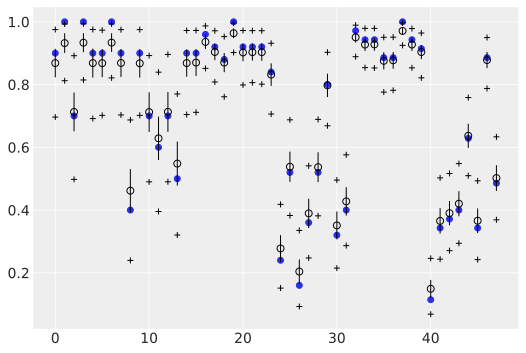

In [12]:
plot_post_check(
    m1_base,
    (range(0, len(d)), d.propsurv.values),
    dict(density=d.density.values, tank=d.tank.values),
    "p" 
)

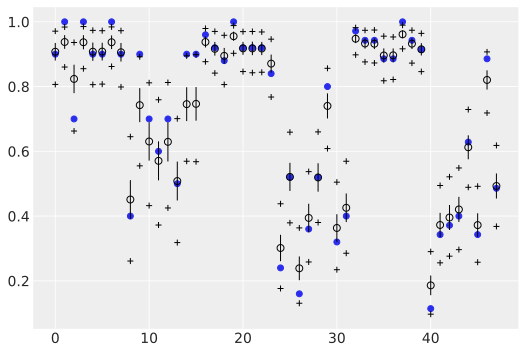

In [13]:
plot_post_check(
    m1_pred,
    (range(0, len(d)), d.propsurv.values),
    dict(density=d.density.values, tank=d.tank.values),
    "p"
)

---

In [14]:
def model(tank, density, is_pred, is_big, surv):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Cauchy(a_bar, sigma), sample_shape=tank.shape)
    logit_p = a[tank]
    numpyro.sample("surv", dist.Binomial(density, logits=logit_p), obs=surv)

m2 = MCMC(NUTS(model), 1000, 2000, num_chains=4)
m2.run(random.PRNGKey(1), **data)
m2.print_summary()
m2_post = m2.get_samples(group_by_chain=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.01      0.86      1.90      0.63      3.28   5518.73      1.00
      a[1]      6.46     10.62      3.45      0.66     12.43    376.75      1.01
      a[2]      1.11      0.61      1.10      0.17      2.17   9064.56      1.00
      a[3]     12.08     41.48      3.63      0.70     15.11     49.05      1.07
      a[4]      2.02      0.86      1.90      0.71      3.37   5508.68      1.00
      a[5]      2.02      0.88      1.90      0.64      3.30   4569.17      1.00
      a[6]      8.77     18.95      3.48      0.55     15.56     61.09      1.07
      a[7]      2.01      0.84      1.91      0.74      3.29   4886.99      1.00
      a[8]     -0.08      0.67     -0.06     -1.20      1.00   9255.44      1.00
      a[9]      2.00      0.86      1.88      0.76      3.32   3615.18      1.00
     a[10]      1.09      0.60      1.09      0.10      2.07   8586.49      1.00
     a[11]      0.73      0

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

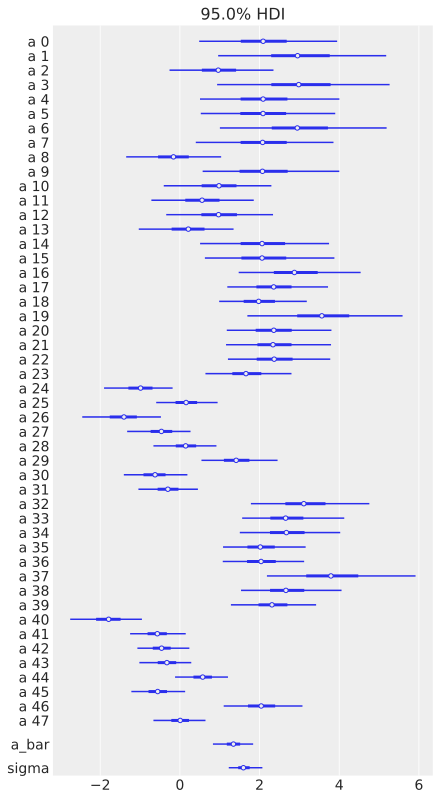

In [15]:
az.plot_forest(m1_base_post, var_names=["a", "a_bar", "sigma"], combined=True, hdi_prob=0.95)
# plt.gca().set(xlim=(-2, 40))

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

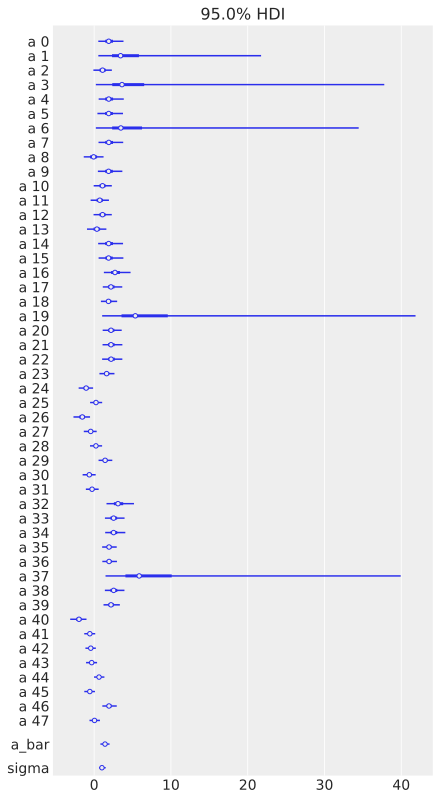

In [16]:
az.plot_forest(m2_post, combined=True, hdi_prob=0.95)

In [17]:
m1_base_means = jnp.mean(m1_base.get_samples()["a"],0)
m2_means = jnp.mean(m2.get_samples()["a"],0)

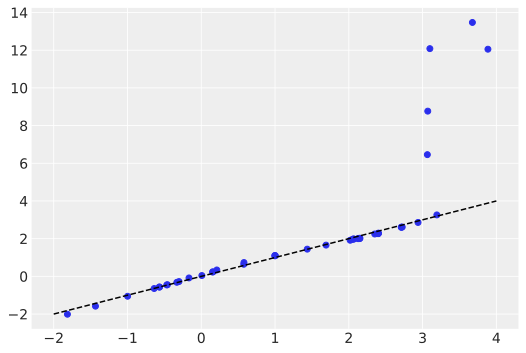

In [18]:
plt.scatter(m1_base_means, m2_means)
plt.plot(range(-2,5), range(-2,5), '--k')

In [19]:
d[list(m2_means > 5)]

,density,pred,size,surv,propsurv,tank,is_pred,is_big
1,10,no,big,10,1.0,1,0,1
3,10,no,big,10,1.0,3,0,1
6,10,no,small,10,1.0,6,0,0
19,25,no,big,25,1.0,19,0,1
37,35,no,small,35,1.0,37,0,0


---

In [20]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat_list = dict(
    pulled_left=d.pulled_left.values,
    actor=d.actor.values - 1,
    block_id=d.block.values - 1,
    treatment=d.treatment.values - 1,
)

def model(actor, block_id, treatment, pulled_left=None, link=False):
    # hyper-priors
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma_a = numpyro.sample("sigma_a", dist.Exponential(1))
    sigma_g = numpyro.sample("sigma_g", dist.Exponential(1))
    # adaptive priors
    a = numpyro.sample("a", dist.Normal(a_bar, sigma_a), sample_shape=(7,))
    g = numpyro.sample("g", dist.Normal(0, sigma_g), sample_shape=(6,))
    b = numpyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + g[block_id] + b[treatment]
    if link:
        numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m13_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_4.run(random.PRNGKey(0), **dat_list)
m13_4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.33      0.37     -0.33     -0.88      0.34    454.56      1.00
      a[1]      4.66      1.31      4.40      2.74      6.55    531.26      1.00
      a[2]     -0.63      0.38     -0.63     -1.28     -0.04    403.13      1.00
      a[3]     -0.64      0.37     -0.62     -1.27     -0.08    488.10      1.00
      a[4]     -0.34      0.38     -0.34     -0.92      0.27    430.02      1.00
      a[5]      0.61      0.38      0.60      0.02      1.28    424.19      1.00
      a[6]      2.14      0.47      2.14      1.35      2.87    533.83      1.00
     a_bar      0.64      0.71      0.64     -0.51      1.75    891.71      1.00
      b[0]     -0.15      0.30     -0.15     -0.66      0.34    430.98      1.00
      b[1]      0.37      0.30      0.38     -0.10      0.88    465.62      1.00
      b[2]     -0.50      0.30     -0.50     -1.01     -0.01    470.68      1.00
      b[3]      0.26      0

In [21]:
def model(actor, block_id, treatment, pulled_left=None, link=False):
    # hyper-priors
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1.5))
    g_bar = numpyro.sample("g_bar", dist.Normal(0, 1.5))
    sigma_a = numpyro.sample("sigma_a", dist.Exponential(1))
    sigma_g = numpyro.sample("sigma_g", dist.Exponential(1))
    # adaptive priors
    a = numpyro.sample("a", dist.Normal(a_bar, sigma_a), sample_shape=(7,))
    g = numpyro.sample("g", dist.Normal(g_bar, sigma_g), sample_shape=(6,))
    b = numpyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + g[block_id] + b[treatment]
    if link:
        numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m_m4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m_m4.run(random.PRNGKey(0), **dat_list)
m_m4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.71      1.12     -0.58     -2.68      0.88    109.86      1.07
      a[1]      4.34      1.49      4.37      2.02      6.85    203.66      1.01
      a[2]     -1.00      1.13     -0.90     -2.89      0.64    103.70      1.08
      a[3]     -1.02      1.12     -0.92     -2.98      0.54    110.25      1.07
      a[4]     -0.69      1.13     -0.60     -2.69      0.86    102.32      1.08
      a[5]      0.21      1.11      0.36     -1.71      1.82    120.69      1.05
      a[6]      1.74      1.13      1.88     -0.25      3.38    127.96      1.05
     a_bar      0.21      1.06      0.18     -1.61      1.93    253.15      1.01
      b[0]     -0.15      0.29     -0.19     -0.61      0.34    258.13      1.03
      b[1]      0.40      0.29      0.42     -0.06      0.91    354.17      1.01
      b[2]     -0.51      0.30     -0.52     -0.98     -0.04     77.82      1.08
      b[3]      0.26      0

In [22]:
az.compare(
    {
        "m13_4": az.from_numpyro(m13_4),
        "m_m4": az.from_numpyro(m_m4),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_m4,0,531.121,10.3059,0,0.743872,19.9496,0,False,deviance
m13_4,1,533.284,11.2878,2.16277,0.256128,19.7864,0.437346,False,deviance


---

In [23]:
bangladesh = pd.read_csv('../data/bangladesh.csv', sep=';')
d = bangladesh
d.columns = [c.replace('.', '_') for c in d.columns]
print(d.shape)
d.head()

(1934, 6)


,woman,district,use_contraception,living_children,age_centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


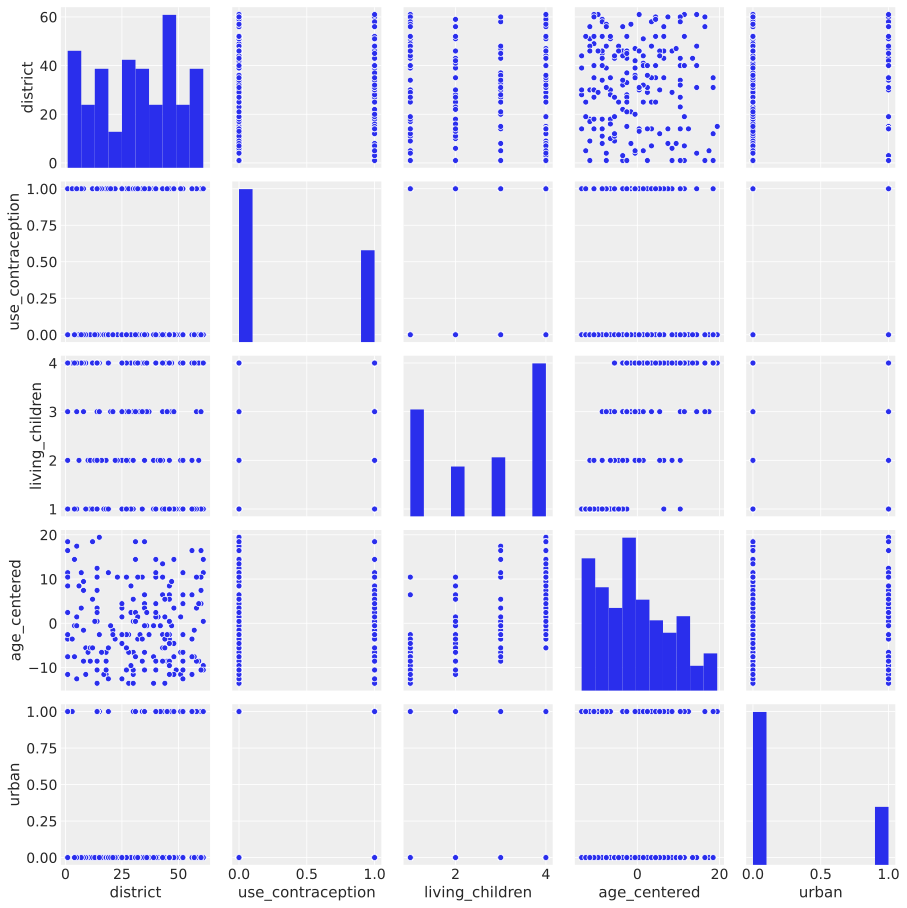

In [24]:
import seaborn as sns
sns.pairplot(d[["district",	"use_contraception", "living_children",	"age_centered",	"urban"]].sample(200))

In [25]:
assert len(set(d.district.unique())) == len(d), f'only {len(set(d.district))} districts, expected {d.district.max()}'

AssertionError: only 60 districts, expected 61

In [26]:
d["district_id"] = 1 + pd.factorize(d.district)[0]
print(set(d.district_id.unique()))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}


In [27]:
def model(use_contraception=None, district_id=None, link=False):
    a = numpyro.sample("a", dist.Normal(0,5), sample_shape=(len(set(district_id)),))
    logit_p = a[district_id]
    if link:
        p = numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("use_contraception", dist.Bernoulli(logits=logit_p), obs=use_contraception)

data = {
    "use_contraception": d.use_contraception.values,
    "district_id": d.district_id.values,
}
mh1_fixed = MCMC(NUTS(model), 500, 500, num_chains=4)
mh1_fixed.run(random.PRNGKey(0), **data)
mh1_fixed.print_summary()
mh1_fixed_post = mh1_fixed.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.02      4.99      0.08     -8.49      8.05   2690.64      1.00
      a[1]     -1.08      0.21     -1.07     -1.45     -0.74   2230.70      1.00
      a[2]     -0.64      0.45     -0.63     -1.33      0.12   2365.93      1.00
      a[3]      4.49      3.09      3.94     -0.42      9.14   1533.62      1.00
      a[4]      0.00      0.37      0.00     -0.58      0.63   2802.17      1.00
      a[5]     -0.59      0.34     -0.59     -1.19     -0.08   3140.57      1.00
      a[6]     -0.90      0.27     -0.90     -1.33     -0.46   2916.12      1.00
      a[7]     -1.01      0.55     -1.00     -1.87     -0.10   2948.89      1.00
      a[8]     -0.51      0.33     -0.51     -1.02      0.06   2975.35      1.00
      a[9]     -0.86      0.46     -0.86     -1.63     -0.16   2608.12      1.00
     a[10]     -2.81      1.12     -2.69     -4.47     -1.03   1651.46      1.00
     a[11]     -6.24      2

In [28]:
def model(use_contraception=None, district_id=None, link=False):
    a_bar = numpyro.sample("a_bar", dist.Normal(0, 5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=(len(set(district_id)),))
    logit_p = a[district_id]
    if link:
        p = numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("use_contraception", dist.Bernoulli(logits=logit_p), obs=use_contraception)

mh1_pooled = MCMC(NUTS(model), 500, 500, num_chains=4)
mh1_pooled.run(random.PRNGKey(0), **data)
mh1_pooled.print_summary()
mh1_pooled_post = mh1_pooled.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.54      0.54     -0.53     -1.47      0.32   1708.20      1.00
      a[1]     -1.00      0.19     -0.98     -1.31     -0.69   1473.84      1.00
      a[2]     -0.57      0.34     -0.58     -1.10      0.02   1646.99      1.00
      a[3]     -0.24      0.50     -0.25     -1.07      0.56   1489.79      1.00
      a[4]     -0.18      0.30     -0.19     -0.67      0.29   1621.03      1.00
      a[5]     -0.57      0.28     -0.57     -1.00     -0.08   1835.68      1.00
      a[6]     -0.81      0.24     -0.81     -1.21     -0.41   1300.65      1.00
      a[7]     -0.76      0.37     -0.75     -1.40     -0.19   1648.43      1.00
      a[8]     -0.52      0.28     -0.51     -0.97     -0.05   1517.93      1.00
      a[9]     -0.71      0.35     -0.70     -1.30     -0.16   1890.79      1.00
     a[10]     -1.15      0.45     -1.12     -1.82     -0.38    734.63      1.01
     a[11]     -1.56      0

In [29]:
az.compare(
    {"mh1_fixed": az.from_numpyro(mh1_fixed), "mh1_pooled": az.from_numpyro(mh1_pooled)},
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mh1_pooled,0,2511.5,34.5933,0,0.922552,32.8158,0,False,deviance
mh1_fixed,1,2529.19,60.1492,17.6945,0.0774485,25.7842,11.6951,True,deviance


In [30]:
d_dist = d.groupby('district_id')['use_contraception'] \
            .agg(pct=lambda x: x.sum() / len(x), cnt=lambda x: len(x)) \
            .sort_values(by='cnt') \
            .reset_index()            
x = d_dist.district_id.values

mh1_fixed_probs = Predictive(mh1_fixed.sampler.model, mh1_fixed_post)(
    random.PRNGKey(1), district_id=x, link=True
)["p"]
mh1_pooled_probs = Predictive(mh1_pooled.sampler.model, mh1_pooled_post)(
    random.PRNGKey(1), district_id=x, link=True
)["p"]

d_dist.head(2)

,district_id,pct,cnt
0,3,1.0,2
1,49,0.0,4


<ErrorbarContainer object of 3 artists>

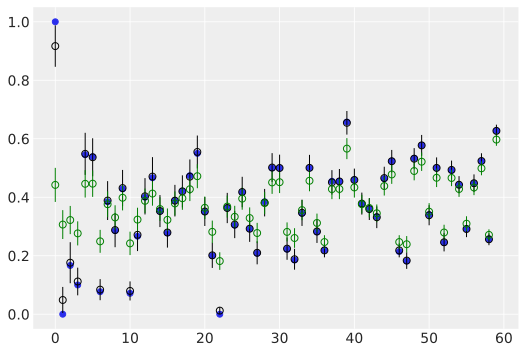

In [31]:
d_dist["p_fixed"] = jnp.mean(mh1_fixed_probs[d_dist.district_id.unique()], 0)
d_dist["p_pooled"] = jnp.mean(mh1_pooled_probs[d_dist.district_id.unique()], 0)

plt.scatter(range(0, len(d_dist)), d_dist.pct.values)
plt.errorbar(
    range(0, len(d_dist)),
    jnp.mean(mh1_fixed_probs, 0),
    jnp.std(mh1_fixed_probs, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.errorbar(
    range(0, len(d_dist)),
    jnp.mean(mh1_pooled_probs, 0),
    jnp.std(mh1_pooled_probs, 0) / 2,
    fmt="o",
    c="g",
    mfc="none",
    ms=7,
    elinewidth=1,
)
# plt.plot(x, jnp.percentile(pred, 5.5, 0), "k+")
# plt.plot(x, jnp.percentile(pred, 94.5, 0), "k+")

---

In [98]:
Trolley = pd.read_csv("../data/Trolley.csv", sep=";")
d = Trolley
d["person_id"] = pd.factorize(d.id)[0]
d["story_id"] = pd.factorize(d.story)[0]
assert len(d.person_id.unique() == len(d.id.unique()))
print(d.shape)
d.sample(3)

(9930, 14)


,case,response,order,id,age,male,edu,action,intention,contact,story,action2,person_id,story_id
8219,nfrub,4,26,97;844,18,0,Some High School,1,0,0,rub,1,273,2
7774,cibur,7,29,97;780,32,1,Master's Degree,0,1,1,bur,1,259,1
3026,ilsha,4,21,96;978,28,0,Some College,0,1,0,sha,0,100,9


In [99]:
def model(R, participant_id=None):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=R)

m12_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_4.run(random.PRNGKey(0), R=d.response.values - 1)
m12_4.print_summary()
m12_4_post = m12_4.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -1.44      0.82     -1.90     -1.95     -0.03      2.00     33.97
cutpoints[1]     -0.15      1.93     -1.25     -1.29      3.18      2.00     97.87
cutpoints[2]      1.56      3.95     -0.71     -0.74      8.40      2.00    233.30
cutpoints[3]      3.08      4.91      0.26      0.23     11.58      2.00    310.08
cutpoints[4]      3.62      4.72      0.90      0.87     11.79      2.00    263.28
cutpoints[5]      4.43      4.61      1.78      1.74     12.40      2.00    204.93

Number of divergences: 0


In [100]:
def model(R, person_id=None, action=None, intention=None, contact=None):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    bA = numpyro.sample("bA", dist.Normal(0, 10))
    bI = numpyro.sample("bI", dist.Normal(0, 10))
    bC = numpyro.sample("bC", dist.Normal(0, 10))
    a = numpyro.sample("a", dist.Normal(0, 10))
    phi = a + bA * action + bI * intention + bC * contact

    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)

mh1_base = MCMC(NUTS(model), 500, 500, num_chains=4, progress_bar=True)
mh1_base.run(random.PRNGKey(0),
    R=d.response.values - 1,
    person_id=d.person_id.values,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
)

mh1_base_post = mh1_base.get_samples()

In [101]:
def model(R, person_id=None, action=None, intention=None, contact=None):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    bA = numpyro.sample("bA", dist.Normal(0, 10))
    bI = numpyro.sample("bI", dist.Normal(0, 10))
    bC = numpyro.sample("bC", dist.Normal(0, 10))

    a = numpyro.sample("a", dist.Normal(0, 10), sample_shape=(len(set(person_id)),))
    phi = a[person_id] + bA * action + bI * intention + bC * contact

    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)

mh1_fe = MCMC(NUTS(model), 500, 500, num_chains=4)
mh1_fe.run(random.PRNGKey(0),
    R=d.response.values - 1,
    person_id=d.person_id.values,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
)
mh1_fe_post = mh1_fe.get_samples()
# mh1_fe.print_summary()

In [102]:
def model(R, person_id=None, action=None, intention=None, contact=None):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()),
    )
    bA = numpyro.sample("bA", dist.Normal(0, 10))
    bI = numpyro.sample("bI", dist.Normal(0, 10))
    bC = numpyro.sample("bC", dist.Normal(0, 10))

    a_bar = numpyro.sample("a_bar", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=(len(set(person_id)),))
    phi = a[person_id] + bA * action + bI * intention + bC * contact

    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)

mh1_ve = MCMC(NUTS(model), 500, 1000, num_chains=4)
mh1_ve.run(random.PRNGKey(0),
    R=d.response.values - 1,
    person_id=d.person_id.values,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
)
mh1_ve_post = mh1_ve.get_samples()

In [103]:
az.compare(
    {
        "m12_4": az.from_numpyro(m12_4),
        "mh1_base": az.from_numpyro(mh1_base),
        "mh1_fe": az.from_numpyro(mh1_fe),
        "mh1_ve": az.from_numpyro(mh1_ve),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mh1_ve,0,31338.8,354.285,0,0.919012,1918.57,0,True,deviance
mh1_fe,1,31359.1,387.089,20.2632,0.0809875,78.0545,14.7435,True,deviance
mh1_base,2,37090.1,9.12866,5751.29,0,186.452,172.341,False,deviance
m12_4,3,274613,117606,243274,0,174.917,1948.73,True,deviance


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

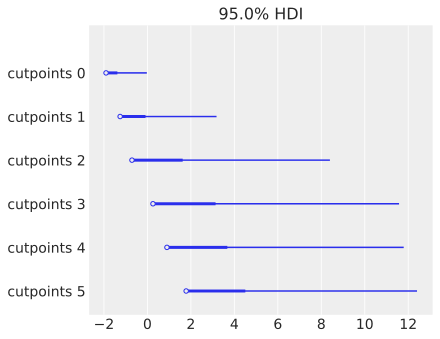

In [104]:
az.plot_forest(m12_4.get_samples(group_by_chain=True), combined=True, hdi_prob=0.95)

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

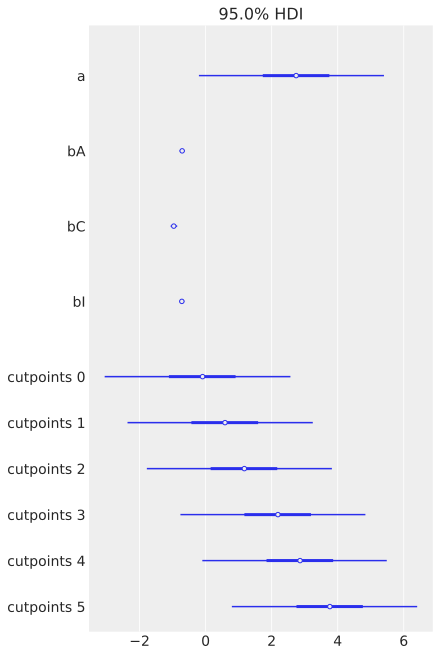

In [105]:
az.plot_forest(mh1_base.get_samples(group_by_chain=True), combined=True, hdi_prob=0.95)

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

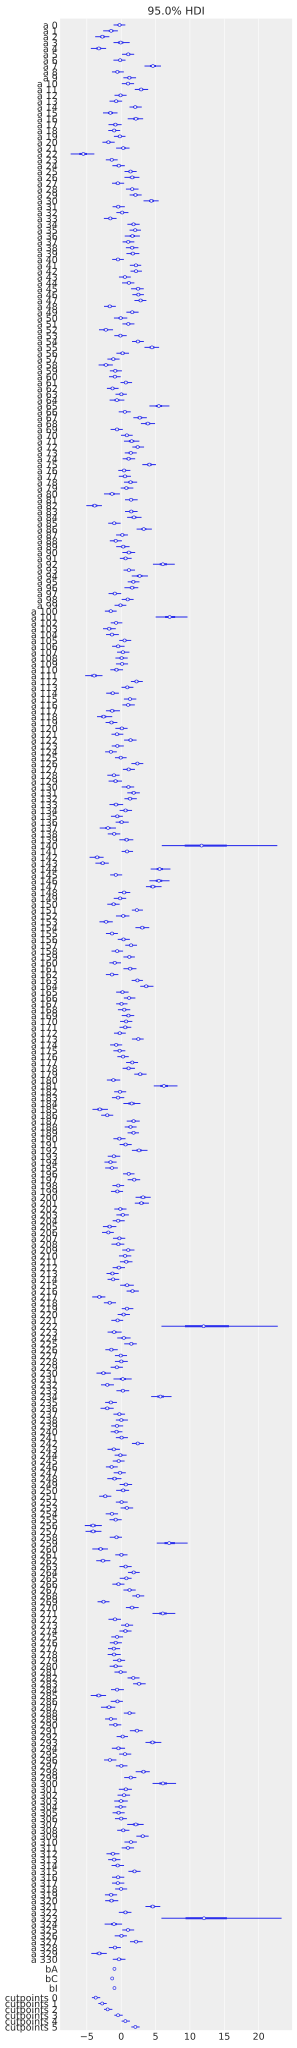

In [106]:
az.plot_forest(mh1_fe.get_samples(group_by_chain=True), combined=True, hdi_prob=0.95)

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

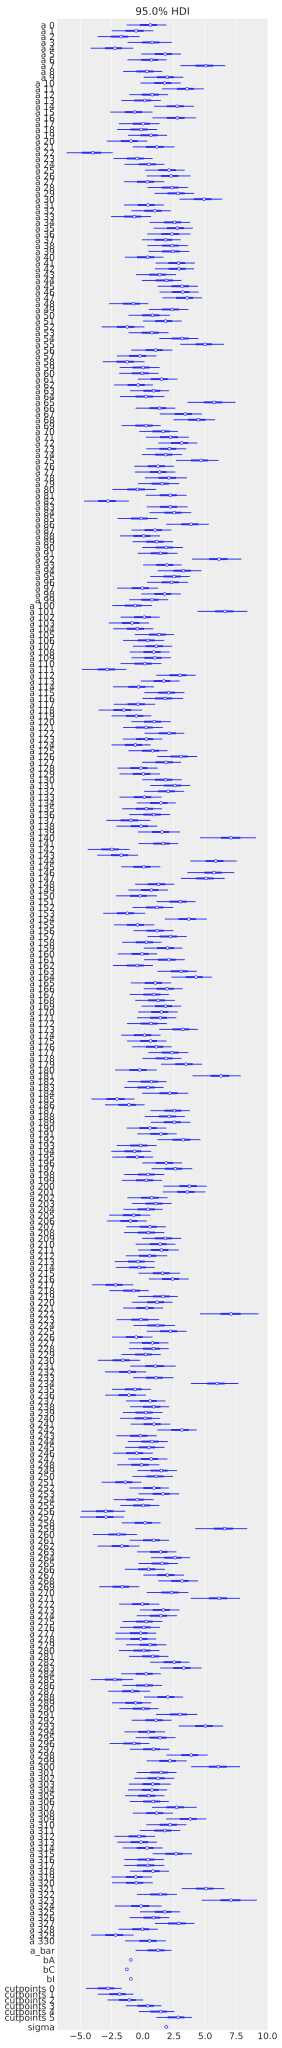

In [107]:
az.plot_forest(mh1_ve.get_samples(group_by_chain=True), combined=True, hdi_prob=0.95)

In [108]:
large_as = jnp.where(jnp.mean(mh1_fe_post['a'], 0) > 10)[0]
d_large_as = d[d.person_id.isin(large_as)].sort_values(by='person_id')
d_large_as.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,person_id,story_id
4200,cfaqu,7,2,97;264,57,1,Master's Degree,0,0,1,aqu,1,140,0
4229,nfrub,7,7,97;264,57,1,Master's Degree,1,0,0,rub,1,140,2
4228,ilswi,7,24,97;264,57,1,Master's Degree,0,1,0,swi,0,140,7
4227,ilshi,7,26,97;264,57,1,Master's Degree,0,1,0,shi,0,140,11
4226,ilsha,7,21,97;264,57,1,Master's Degree,0,1,0,sha,0,140,9


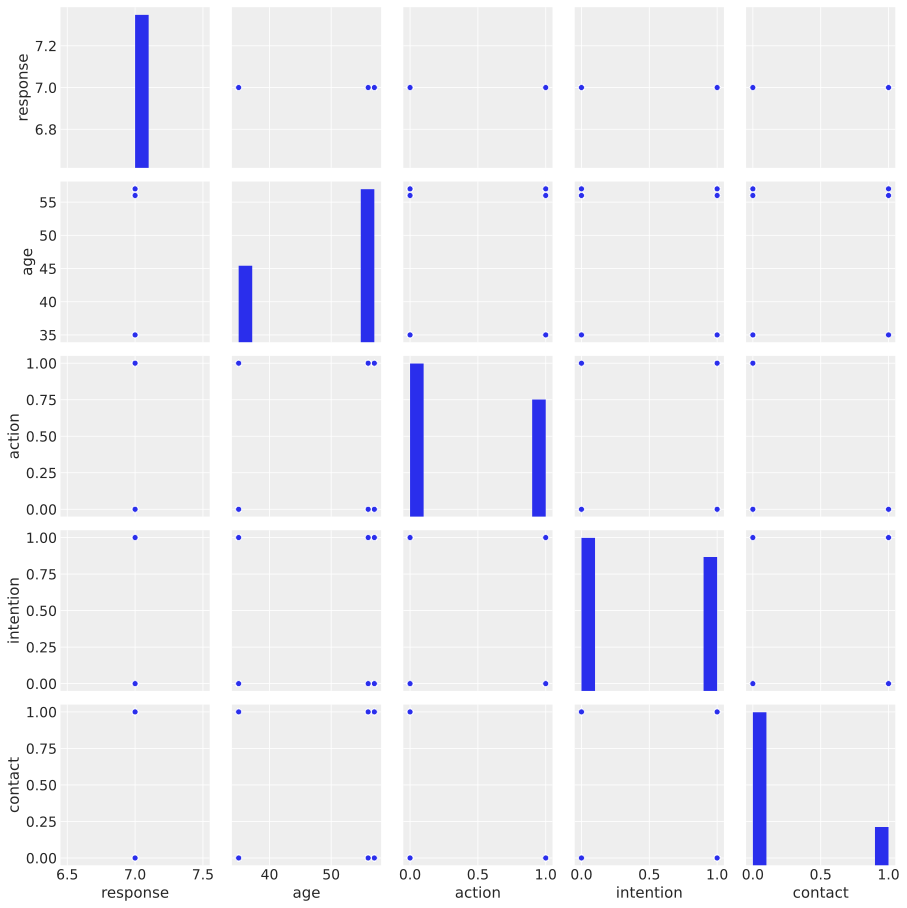

In [109]:
sns.pairplot(d_large_as[['response', 'age', 'action', 'intention', 'contact']])

In [110]:
d.groupby('person_id').response.nunique().value_counts()

5    79
6    77
4    54
7    43
3    41
2    29
1     8
Name: response, dtype: int64

In [111]:
d.person_id.value_counts().value_counts()

30    331
Name: person_id, dtype: int64

---

In [113]:
def model(R, person_id=None, action=None, intention=None, contact=None, story_id=None):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()),
    )
    bA = numpyro.sample("bA", dist.Normal(0, 10))
    bI = numpyro.sample("bI", dist.Normal(0, 10))
    bC = numpyro.sample("bC", dist.Normal(0, 10))

    a_person_bar = numpyro.sample("a_person_bar", dist.Normal(0, 10))
    sigma_person = numpyro.sample("sigma_person", dist.Exponential(1))
    sigma_story = numpyro.sample("sigma_story", dist.Exponential(1))
    a_person = numpyro.sample("a_person",
        dist.Normal(a_person_bar, sigma_person), sample_shape=(len(set(person_id)),)
    )
    a_story = numpyro.sample("a_story",
        dist.Normal(0, sigma_story), sample_shape=(len(set(story_id)),)
    )
    phi = a_person[person_id] + a_story[story_id] + bA * action + bI * intention + bC * contact

    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)

mh1_ve_story = MCMC(NUTS(model), 500, 1000, num_chains=4)
mh1_ve_story.run(random.PRNGKey(0),
    R=d.response.values - 1,
    person_id=d.person_id.values,
    story_id=d.story_id.values,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
)
mh1_ve_story_post = mh1_ve_story.get_samples()

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

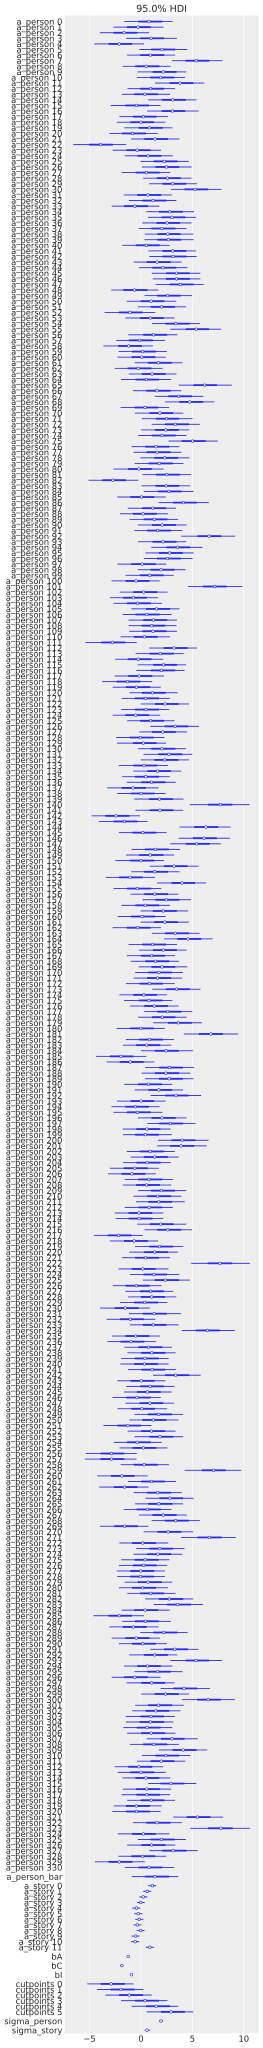

In [114]:
az.plot_forest(mh1_ve_story.get_samples(group_by_chain=True), combined=True, hdi_prob=0.95)

In [116]:
az.compare(
    {
        "m12_4": az.from_numpyro(m12_4),
        "mh1_base": az.from_numpyro(mh1_base),
        "mh1_fe": az.from_numpyro(mh1_fe),
        "mh1_ve": az.from_numpyro(mh1_ve),
        "mh1_ve_story": az.from_numpyro(mh1_ve_story),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mh1_ve_story,0,30688.4,364.601,0,1,1891.54,0,True,deviance
mh1_ve,1,31338.8,354.285,650.459,1.07455e-113,76.4611,48.4025,True,deviance
mh1_fe,2,31359.1,387.089,670.722,2.53449e-116,191.477,51.592,True,deviance
mh1_base,3,37090.1,9.12866,6401.75,0,179.256,174.834,False,deviance
m12_4,4,274613,117606,243924,0,182.269,1948.72,True,deviance


In [176]:
stories = d[["story_id", "story"]].drop_duplicates().set_index('story_id').to_dict()['story']
print(stories)

{0: 'aqu', 1: 'bur', 2: 'rub', 3: 'box', 4: 'spe', 5: 'boa', 6: 'car', 7: 'swi', 8: 'che', 9: 'sha', 10: 'pon', 11: 'shi'}


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

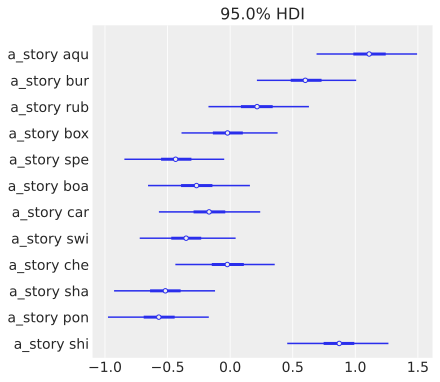

In [187]:
story_samples = mh1_ve_story.get_samples(group_by_chain=True)
az.plot_forest(
    story_samples,
    var_names=['a_story'],
    combined=True,
    transform=lambda x: x.assign_coords(a_story_dim_0=list(stories.values())),
    hdi_prob=0.95
)